Step 1: Load the Data which is prepared from the nuscenes dataset

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from pyquaternion import Quaternion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
# Load the Excel file
df = pd.read_excel('Filtered_PCD_Annotations_AB.xlsx')


In [14]:
print(df.columns.tolist())

['a_sample_token', 'a_x_global', 'a_y_global', 'a_z_global', 'a_radar_token', 'a_radar_x', 'a_radar_y', 'a_radar_z', 'a_radar_cam_x', 'a_radar_cam_y', 'a_radar_cam_z', 'a_dyn_prop', 'a_cluster_id', 'a_rcs', 'a_vx', 'a_vy', 'a_vx_comp', 'a_vy_comp', 'a_is_quality_valid', 'a_ambig_state', 'a_x_rms', 'a_y_rms', 'a_invalid_state', 'a_pdh0', 'a_vx_rms', 'a_vy_rms', 'a_image_coord_x', 'a_image_coord_y', 'a_depth', 'a_depth_patch', 'a_scene_name', 'a_scene_token', 'a_timestamp', 'a_annotation_token', 'a_category', 'a_instance_token', 'a_center_x', 'a_center_y', 'a_center_z', 'a_length', 'a_width', 'a_height', 'a_rotation_w', 'a_rotation_x', 'a_rotation_y', 'a_rotation_z', 'a_yaw', 'a_num_lidar_pts', 'a_num_radar_pts', 'a_distance', 'a_can_timestamp', 'a_brake', 'a_brake_switch', 'a_rear_left_rpm', 'a_rear_right_rpm', 'a_can_utime', 'a_vehicle_speed', 'a_yaw_rate', 'a_next_token', 'a_radar_pcd_file', 'a_image_file', 'a_camera_pose_x', 'a_camera_pose_y', 'a_camera_pose_z', 'b_sample_token', 'b_

In [93]:
df_eda = df.copy()
df_eda = df_eda[[
    'a_center_x', 'a_center_y', 'a_center_z',
    'a_length', 'a_width', 'a_height', 
    'a_rotation_w', 'a_rotation_x', 'a_rotation_y', 'a_rotation_z', 
    'a_distance', 
    'b_distance', 
    'a_yaw',
    'a_brake', 'a_brake_switch', 'a_rear_left_rpm', 'a_rear_right_rpm', 'a_vehicle_speed', 'a_yaw_rate',
    'a_image_coord_x', 'a_image_coord_y', 
    'b_image_coord_x', 'b_image_coord_y', 
    'a_depth', 
    'b_depth',
    'a_radar_x', 'a_radar_y', 
    'a_vx', 'a_vy']]

In [94]:
corr_matrix = df_eda.corr()

# Step 2: Get absolute correlations with 'a_radar_x'
corr_with_radar_x = corr_matrix['a_radar_x'].abs()
corr_with_radar_y = corr_matrix['a_radar_x'].abs()
corr_with_radar_vx = corr_matrix['a_vx'].abs()
corr_with_radar_vy = corr_matrix['a_vy'].abs()

# Step 3: Drop self-correlation
corr_with_radar_x = corr_with_radar_x.drop(['a_radar_y', 'a_vx', 'a_vy'])
corr_with_radar_y = corr_with_radar_y.drop(['a_radar_x', 'a_vx', 'a_vy'])
corr_with_radar_vx = corr_with_radar_vx.drop(['a_radar_x', 'a_radar_y', 'a_vy'])
corr_with_radar_vy = corr_with_radar_vy.drop(['a_radar_x', 'a_radar_x', 'a_vx'])

# Step 4: Compute threshold for top 50%
threshold_x = corr_with_radar_x.quantile(0.75)
threshold_y = corr_with_radar_y.quantile(0.75)
threshold_vx = corr_with_radar_vx.quantile(0.75)
threshold_vy = corr_with_radar_vy.quantile(0.75)


# Step 5: Select columns above threshold
top_corr_columns_x = corr_with_radar_x[corr_with_radar_x >= threshold_x].index.tolist()
top_corr_columns_y = corr_with_radar_y[corr_with_radar_y >= threshold_y].index.tolist()
top_corr_columns_vx = corr_with_radar_vx[corr_with_radar_vx >= threshold_vx].index.tolist()
top_corr_columns_vy = corr_with_radar_vy[corr_with_radar_vy >= threshold_vy].index.tolist()


# Step 6: Filter the DataFrame
df_top_corr_x = df_eda[top_corr_columns_x]
df_top_corr_y = df_eda[top_corr_columns_y]
df_top_corr_vx = df_eda[top_corr_columns_vx]
df_top_corr_vy = df_eda[top_corr_columns_vy]


In [99]:
top_corr_columns_x

['a_center_x',
 'a_image_coord_y',
 'b_image_coord_y',
 'a_depth',
 'b_depth',
 'a_radar_x']

In [100]:
top_corr_columns_y

['a_center_x',
 'a_length',
 'a_image_coord_y',
 'b_image_coord_y',
 'a_depth',
 'b_depth']

In [101]:
top_corr_columns_vx

['a_brake',
 'a_brake_switch',
 'a_rear_left_rpm',
 'a_rear_right_rpm',
 'a_vehicle_speed',
 'a_vx']

In [102]:
top_corr_columns_vy

['a_center_y',
 'a_length',
 'a_brake',
 'a_brake_switch',
 'a_yaw_rate',
 'b_image_coord_x',
 'a_vy']

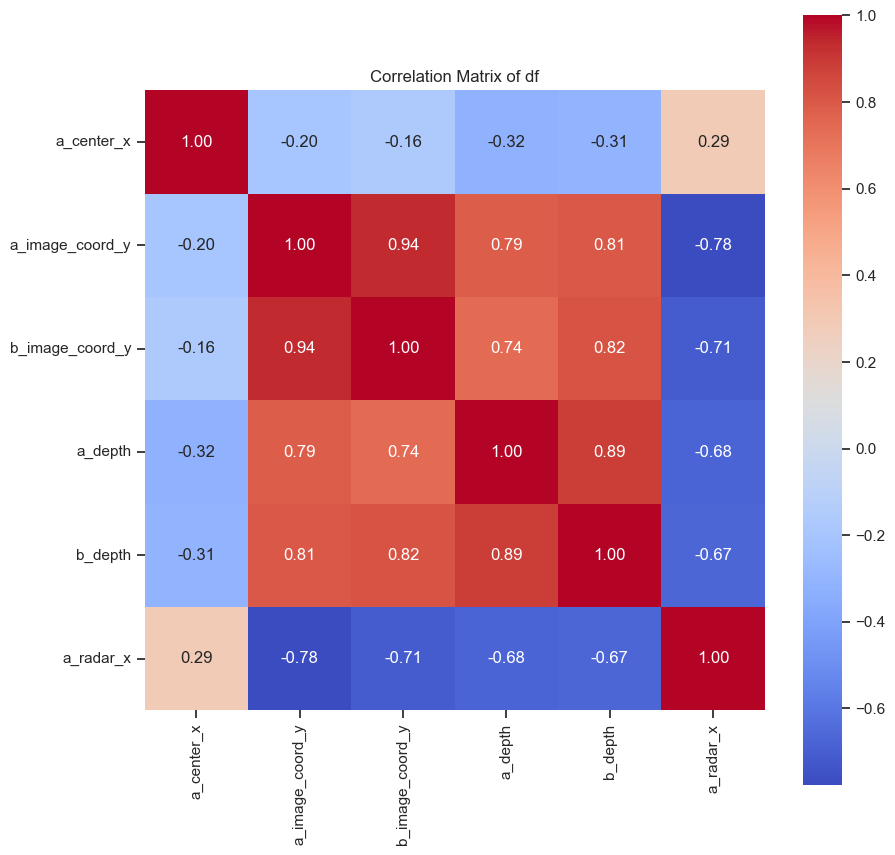

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_top_corr_x.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of df")
plt.show()

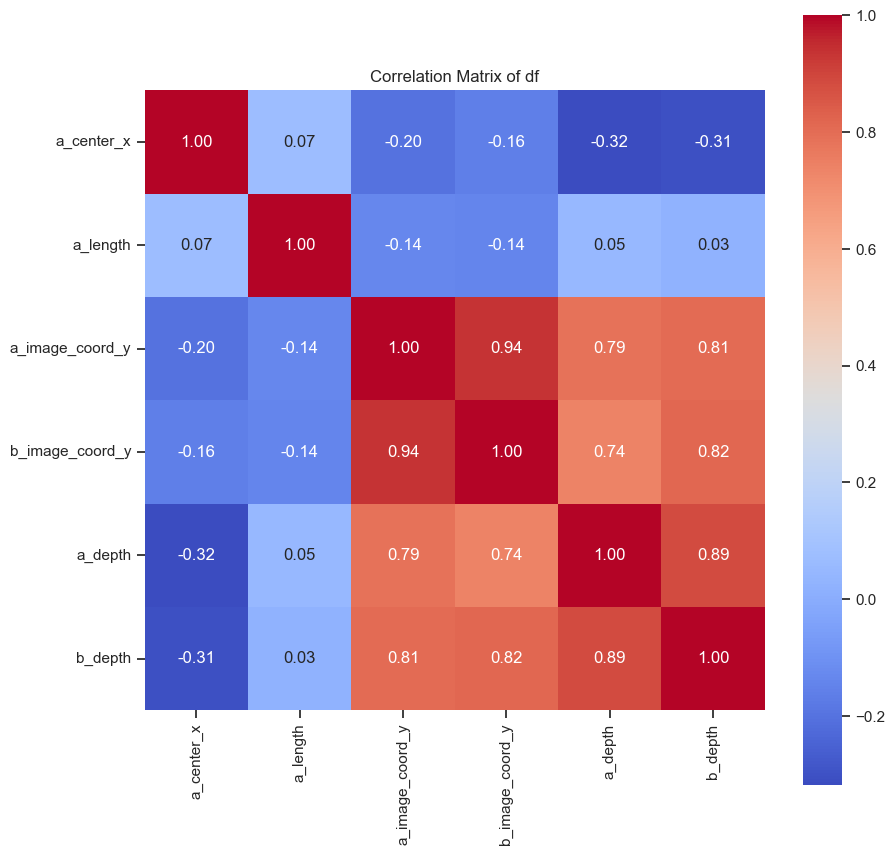

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_top_corr_y.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of df")
plt.show()

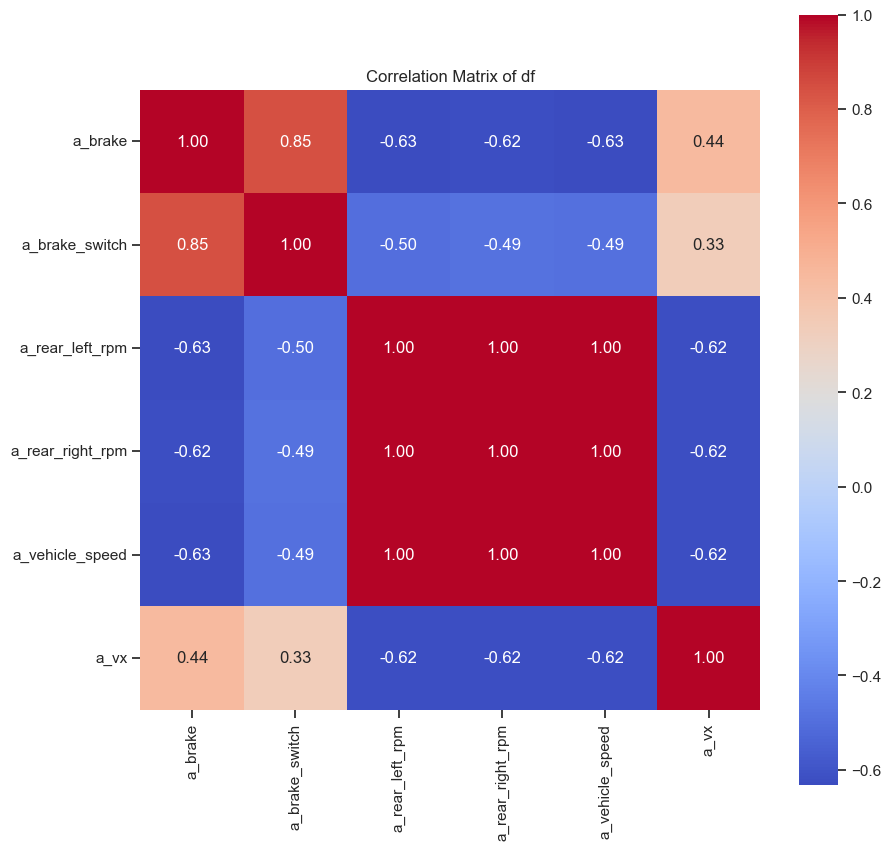

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_top_corr_vx.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of df")
plt.show()

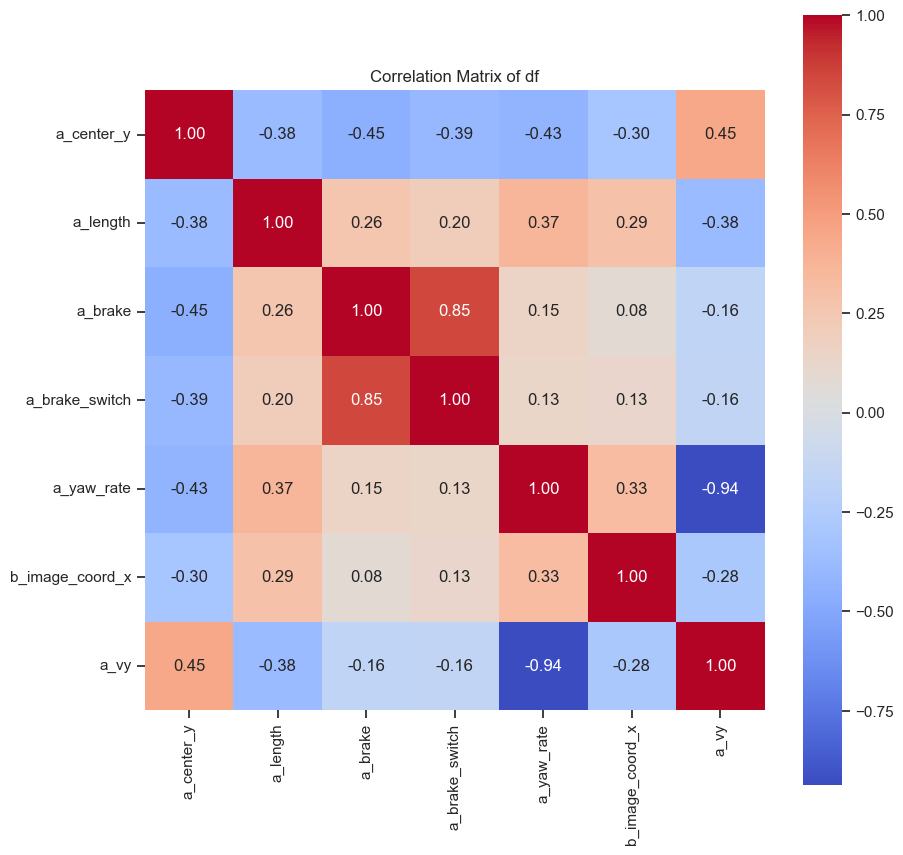

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_top_corr_vy.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of df")
plt.show()

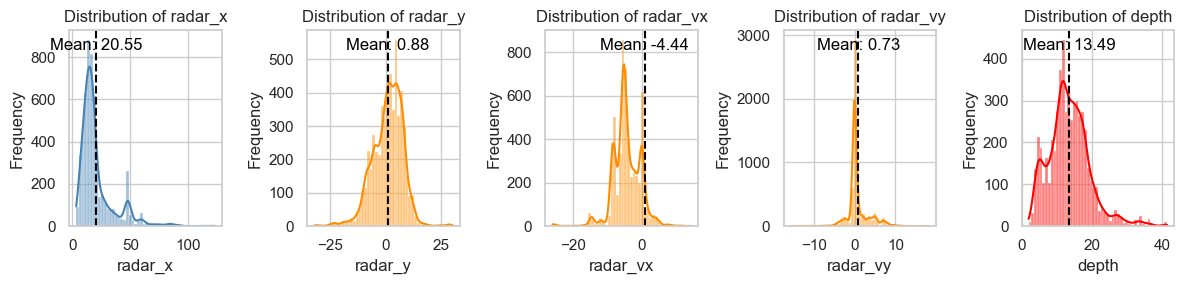

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Compute means
mean_radar_x = df_eda['a_radar_x'].mean()
mean_radar_y = df_eda['a_radar_y'].mean()
mean_radar_vx = df_eda['a_vx'].mean()
mean_radar_vy = df_eda['a_vy'].mean()
mean_depth = df_eda['a_depth'].mean()

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(12, 3))

# Histogram for radar_x
sns.histplot(df_eda['a_radar_x'], bins=50, kde=True, ax=axes[0], color='steelblue')
axes[0].axvline(mean_radar_x, color='black', linestyle='--', linewidth=1.5)
axes[0].text(mean_radar_x, axes[0].get_ylim()[1]*0.9, f'Mean: {mean_radar_x:.2f}', color='black', ha='center')
axes[0].set_title('Distribution of radar_x')
axes[0].set_xlabel('radar_x')
axes[0].set_ylabel('Frequency')

# Histogram for a_radar_y
sns.histplot(df_eda['a_radar_y'], bins=50, kde=True, ax=axes[1], color='darkorange')
axes[1].axvline(mean_radar_y, color='black', linestyle='--', linewidth=1.5)
axes[1].text(mean_radar_y, axes[1].get_ylim()[1]*0.9, f'Mean: {mean_radar_y:.2f}', color='black', ha='center')
axes[1].set_title('Distribution of radar_y')
axes[1].set_xlabel('radar_y')
axes[1].set_ylabel('Frequency')

# Histogram for a_radar_vx
sns.histplot(df_eda['a_vx'], bins=50, kde=True, ax=axes[2], color='darkorange')
axes[2].axvline(mean_radar_y, color='black', linestyle='--', linewidth=1.5)
axes[2].text(mean_radar_y, axes[2].get_ylim()[1]*0.9, f'Mean: {mean_radar_vx:.2f}', color='black', ha='center')
axes[2].set_title('Distribution of radar_vx')
axes[2].set_xlabel('radar_vx')
axes[2].set_ylabel('Frequency')


# Histogram for a_radar_vy
sns.histplot(df_eda['a_vy'], bins=50, kde=True, ax=axes[3], color='darkorange')
axes[3].axvline(mean_radar_y, color='black', linestyle='--', linewidth=1.5)
axes[3].text(mean_radar_y, axes[3].get_ylim()[1]*0.9, f'Mean: {mean_radar_vy:.2f}', color='black', ha='center')
axes[3].set_title('Distribution of radar_vy')
axes[3].set_xlabel('radar_vy')
axes[3].set_ylabel('Frequency')


# Histogram for depth
sns.histplot(df_eda['a_depth'], bins=50, kde=True, ax=axes[4], color='red')
axes[4].axvline(mean_depth, color='black', linestyle='--', linewidth=1.5)
axes[4].text(mean_depth, axes[4].get_ylim()[1]*0.9, f'Mean: {mean_depth:.2f}', color='black', ha='center')
axes[4].set_title('Distribution of depth')
axes[4].set_xlabel('depth')
axes[4].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [48]:
df_pairplot = df_eda[['a_image_coord_x', 'a_image_coord_y', 'a_radar_x', 'a_radar_y', 'a_depth']].copy()
df_pairplot.shape

(5450, 5)

In [45]:
df_pairplot.sample(5)

,a_image_coord_x,a_image_coord_y,a_radar_x,a_radar_y,a_depth,a_image_coord_x,a_image_coord_y
3938,242.778336,577.262859,12.2,6.7,14.761338,242.778336,577.262859
4498,796.103175,603.136266,8.8,0.5,14.539826,796.103175,603.136266
677,1042.286541,607.320770,8.2,-1.9,21.086164,1042.286541,607.320770
3203,534.857442,547.410621,18.0,4.9,13.568118,534.857442,547.410621
4226,-541.370587,660.493125,5.4,7.9,18.941736,-541.370587,660.493125


In [47]:
df_pairplot.dtypes

a_image_coord_x    float64
a_image_coord_y    float64
a_radar_x          float64
a_radar_y          float64
a_depth            float64
a_image_coord_x    float64
a_image_coord_y    float64
dtype: object

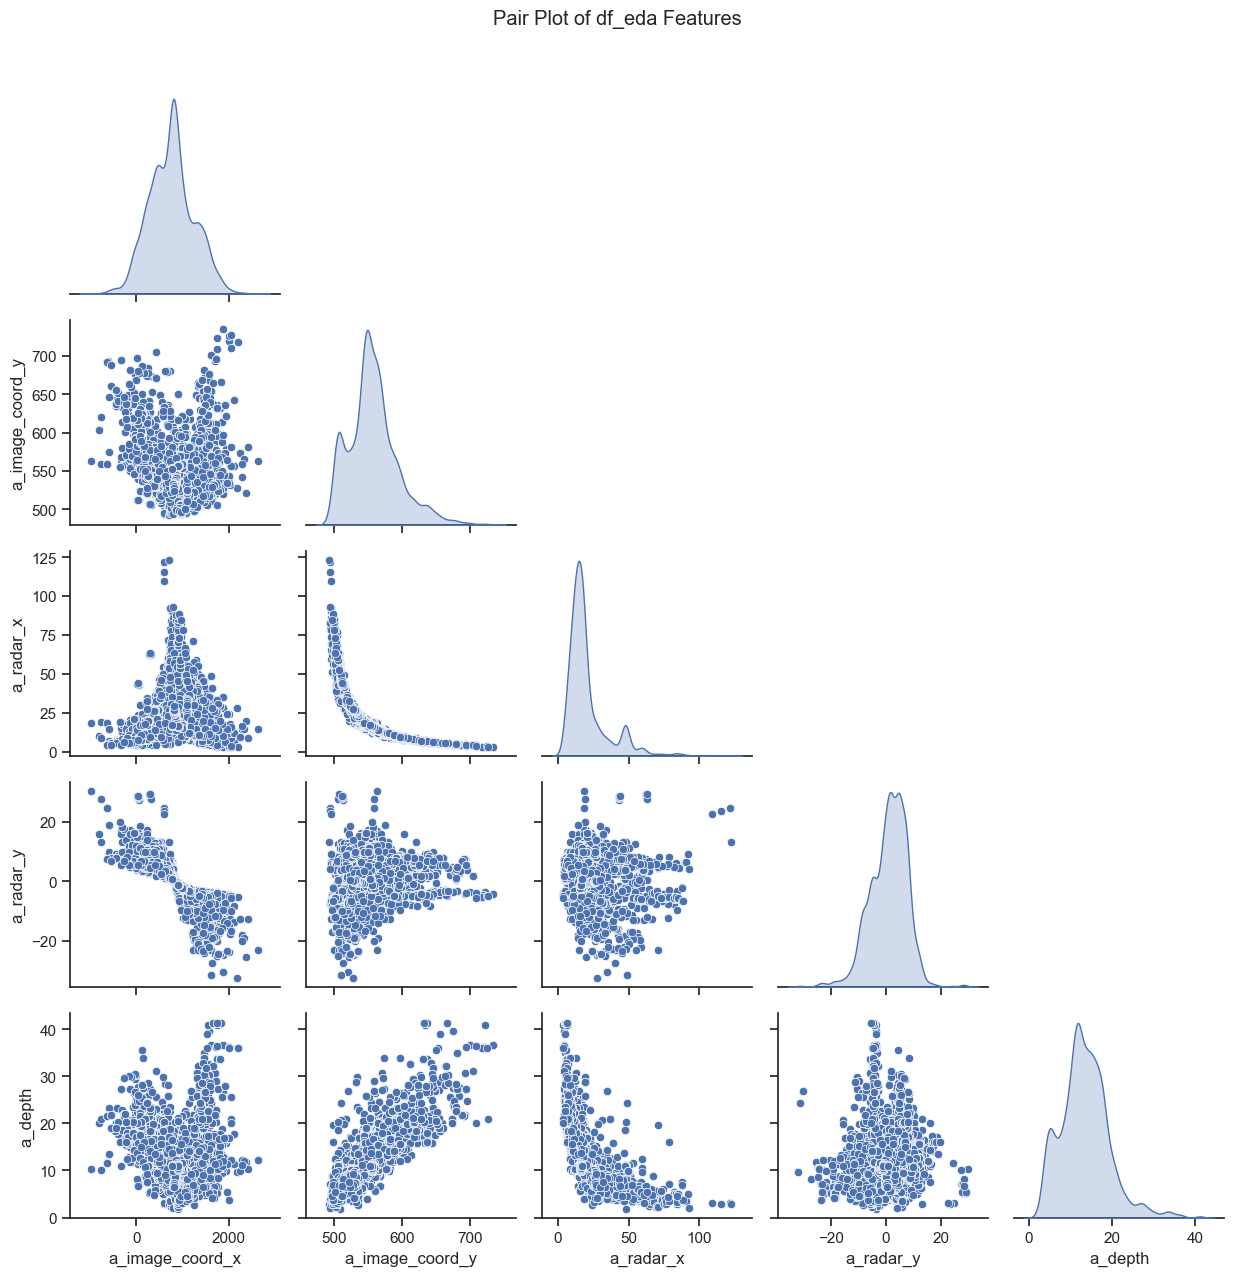

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot aesthetics
sns.set(style="ticks", color_codes=True)


# Generate pair plot
sns.pairplot(df_pairplot, diag_kind="kde", corner=True)

# Show the plot
plt.suptitle("Pair Plot of df_eda Features", y=1.02)
plt.tight_layout()
plt.show()